In [1]:
import ROOT as rt
import array as arr
import math

from strangehelper import make_mixed_corrections, get_straight_line, apply_two_track_correction, get_parabola

Welcome to JupyROOT 6.28/02


In [2]:
rt.gStyle.SetOptStat(0)

In [3]:
PT_MODE = 0

In [4]:
# epsilon used to avoid bin edge nightmares (if you pick a value that lies on bin edge, it defaults to right bin)
EPSILON = 0.00001

In [5]:
# decide whether to do sideband subtraction or not
DO_SIDEBAND_SUBTRACTION = False

In [6]:
# set if correlation distribution uses MC kinematics (instead of reconstructed kinematics)
USE_MC_KINEMATICS = True

In [7]:
# UE line method
USE_AVG = 1
USE_ZYAM = 0
USE_NONEG = 0
assert sum([USE_AVG, USE_ZYAM, USE_NONEG]) == 1, "Only select 1 method for UE line please"

In [8]:
# ETA CUTS
ETA_MIN = -0.8
ETA_MAX = 0.8 - EPSILON
DELTA_ETA_MIN = -1.2
DELTA_ETA_MAX = 1.2 - EPSILON 

In [61]:
# PT CUTS
TRIG_PT_LOW = 4
TRIG_PT_HIGH = 8 - EPSILON

if PT_MODE == 0:
    ASSOC_PT_LOW = 2.0
    ASSOC_PT_HIGH = 4.0 - EPSILON
elif PT_MODE == 1:
    ASSOC_PT_LOW = 1.5
    ASSOC_PT_HIGH = 2.5 - EPSILON
elif PT_MODE == 2:
    ASSOC_PT_LOW = 2.5
    ASSOC_PT_HIGH = 4.0 - EPSILON

In [62]:
# SIGNAL AND SIDEBAND REGION CUTS
SIG_MIN = 1.102
SIG_MAX = 1.130 - EPSILON
RSB_MIN = 1.135
RSB_MAX = 1.50 - EPSILON

In [63]:
c = rt.TCanvas("main_canvas", "Main Canvas", 55, 55, 800, 600)
c.SetLeftMargin(0.15)
c.SetRightMargin(0.05)
c.SetTopMargin(0.05)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: main_canvas


In [12]:
if PT_MODE == 0:
    template_file = rt.TFile("twotrack_template.root")
elif PT_MODE == 1:
    template_file = rt.TFile("twotrack_template_lowpt.root")
elif PT_MODE == 2:
    template_file = rt.TFile("twotrack_template_highpt.root")

TWOTRACK_TEMPLATE = template_file.Get("twotrack_template")

OSError: Failed to open file twotrack_template.root

Error in <TFile::TFile>: file /home/ryan/Wonderland/native/research/lambda-over-hadron/mc/offline/twotrack_template.root does not exist


In [67]:
# input_file = rt.TFile("../online/closure/v0/output/closure_full_stats.root")
# input_file = rt.TFile("../online/closure/v0/output/closure_f2b.root")
input_file = rt.TFile("../online/closure/v0/output/closure_17f2a.root")
# input_file = rt.TFile("../online/closure/v0/output/closure_18f3_FAST_pt1.root")
# input_file = rt.TFile("../online/closure/v0/output/closure_20f11c2_FAST.root")
input_list = input_file.Get("h-lambda")

In [68]:
trig_dist = input_list.FindObject("fTriggerDistEff")
lambda_dist = input_list.FindObject("fGuaranteedLambdaDist")
trig_dist_mc = input_list.FindObject("fTriggerDist_MC")
lambda_dist_mc = input_list.FindObject("fTriggeredLambdaDist_MC")

In [69]:
h_h = input_list.FindObject("fDphiHHEff")
h_h_mixed = input_list.FindObject("fDphiHHMixed")
h_h_mc = input_list.FindObject("fDphiHH_MC")
h_h_mixed_mc = input_list.FindObject("fDphiHHMixed_MC")

In [70]:
h_lambda = input_list.FindObject("fDphiHLambdaEff_MCKin")
# h_lambda = input_list.FindObject("fDphiHGuaranteedLambdaEff")
h_lambda_mixed = input_list.FindObject("fDphiHLambdaMixed_MCKin")
h_lambda_mc = input_list.FindObject("fDphiHLambda_MC")
h_lambda_mixed_mc = input_list.FindObject("fDphiHLambdaMixed_MC")

In [71]:
# Setting the trigger Pt (this is never changed again)
trig_dist.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

h_lambda.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

trig_dist_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

h_lambda_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

In [72]:
# Setting the associated Pt (this is never changed again)
lambda_dist.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
lambda_dist_mc.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mc.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_mc.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mc.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_mc.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)

In [73]:
trig_dist.GetAxis(2).SetRangeUser(ETA_MIN, ETA_MAX)
trig_dist_mc.GetAxis(2).SetRangeUser(ETA_MIN, ETA_MAX)
lambda_dist.GetAxis(2).SetRangeUser(ETA_MIN, ETA_MAX)
lambda_dist_mc.GetAxis(2).SetRangeUser(ETA_MIN, ETA_MAX)

In [74]:
trig_pt_dist = trig_dist.Projection(0).Clone("trig_pt_dist")
trig_phi_dist = trig_dist.Projection(1).Clone("trig_phi_dist")
trig_eta_dist = trig_dist.Projection(2).Clone("trig_eta_dist")
trig_2d_dist = trig_dist.Projection(0, 3).Clone("trig_2d_dist")

trig_pt_dist.SetTitle("Trigger #font[12]{p}_{T} Distribution (red: reconstruced, blue: MC truth)")
trig_pt_dist.Sumw2()
trig_pt_dist.SetLineColor(rt.kRed)

trig_phi_dist.SetTitle("Trigger #varphi Distribution (red: reconstructed, blue: MC truth")
trig_phi_dist.Sumw2()
trig_phi_dist.SetLineColor(rt.kRed)

trig_eta_dist.SetTitle("Trigger #eta Distribution (red: reconstructed, blue: MC truth")
trig_eta_dist.Sumw2()
trig_eta_dist.SetLineColor(rt.kRed)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [75]:
trig_pt_dist_mc = trig_dist_mc.Projection(0).Clone("trig_pt_dist_mc")
trig_phi_dist_mc = trig_dist_mc.Projection(1).Clone("trig_phi_dist_mc")
trig_eta_dist_mc = trig_dist_mc.Projection(2).Clone("trig_eta_dist_mc")
trig_2d_dist_mc = trig_dist_mc.Projection(0, 3).Clone("trig_2d_dist_mc")


trig_pt_dist_mc.SetTitle("Trigger #font[12]{p}_{T} Distribution (red: reconstruced, blue: MC truth)")
trig_pt_dist_mc.Sumw2()
trig_pt_dist_mc.SetLineColor(rt.kBlue)

trig_phi_dist_mc.SetTitle("Trigger #varphi Distribution (red: reconstructed, blue: MC truth")
trig_phi_dist_mc.Sumw2()
trig_phi_dist_mc.SetLineColor(rt.kBlue)

trig_eta_dist_mc.SetTitle("Trigger #eta Distribution (red: reconstructed, blue: MC truth")
trig_eta_dist_mc.Sumw2()
trig_eta_dist_mc.SetLineColor(rt.kBlue)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [76]:
num_trigs = trig_2d_dist.Integral()
num_trigs_mc = trig_2d_dist_mc.Integral()

### Signal analysis section

In [77]:
lambda_mass_dist = lambda_dist.Projection(3).Clone("lambda_mass_dist")
lambda_mass_dist_mc = lambda_dist_mc.Projection(3).Clone("lambda_mass_dist_mc")

In [78]:
lambda_mass_dist.SetTitle("#Lambda^{0} invariant mass distribution (p-#pi)")
lambda_mass_dist.Sumw2()
lambda_mass_dist.SetLineWidth(2)
lambda_mass_dist.GetXaxis().SetTitle("Mass (GeV/c^{2})")
lambda_mass_dist.GetYaxis().SetTitle("#frac{dN_{p-#pi}}{dM}")

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [79]:
bin_1 = lambda_mass_dist.FindBin(1.08)
bin_2 = lambda_mass_dist.FindBin(1.16 - 0.001)
point_one = [1.08, lambda_mass_dist.GetBinContent(bin_1)]
point_two = [1.16 - 0.001, lambda_mass_dist.GetBinContent(bin_2)]
bg_starting_params = get_straight_line(point_one, point_two)

lambda_mass_bg_fit = rt.TF1("bg_fit", "pol1", 1.096, 1.136)
lambda_mass_bg_fit.SetNpx(1000)
lambda_mass_bg_fit.SetParameter(0, bg_starting_params[0])
lambda_mass_bg_fit.SetParameter(1, bg_starting_params[1])

0.007531438313921452


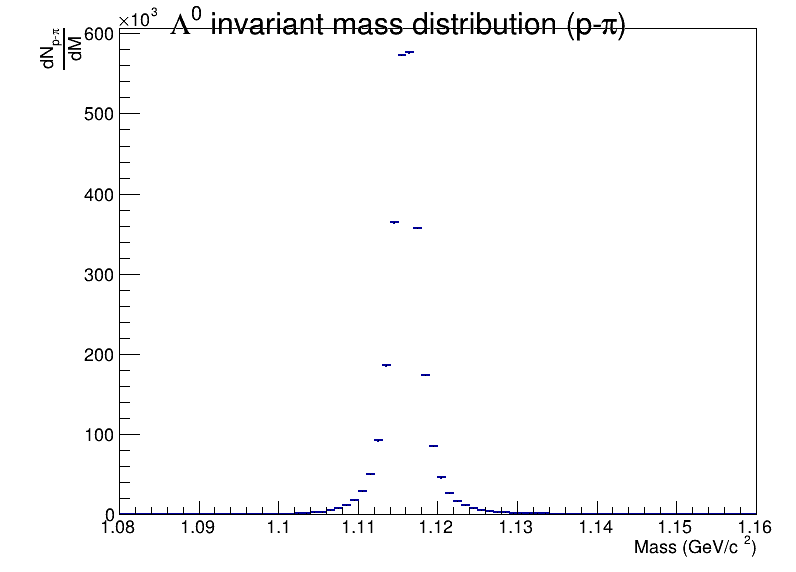

In [80]:
residual = lambda_mass_dist.Clone("residual")
residual.Add(lambda_mass_bg_fit, -1)

residual.GetXaxis().SetRangeUser(1.130, 1.16)
ri1 = residual.Integral()
residual.GetXaxis().SetRangeUser(1.08, 1.102)
ri2 = residual.Integral()
residual.GetXaxis().SetRangeUser(1.08, 1.16)
ri3 = residual.Integral()

print((ri1 + ri2)/ri3)

residual.Draw()
c.Draw()

left_bin = residual.FindBin(SIG_MIN)
right_bin = residual.FindBin(SIG_MAX)

# hand calc from separate analysis
if PT_MODE == 0:
    scale_factor = 1.02
elif PT_MODE == 1:
    scale_factor = 1.015
elif PT_MODE == 2:
    scale_factor = 1.025


In [81]:
left_signal_bin = lambda_mass_dist.FindBin(SIG_MIN)
right_signal_bin = lambda_mass_dist.FindBin(SIG_MAX)

lambda_bg = 0
lambda_total = 0
lambda_bg_test = 0
lambda_total_test = 0

for bin_num in range(left_signal_bin, right_signal_bin + 1):
    lambda_total += lambda_mass_dist.GetBinContent(bin_num)
    lambda_bg += lambda_mass_bg_fit.Eval(lambda_mass_dist.GetBinCenter(bin_num))
lambda_signal = lambda_total - lambda_bg
lambda_signal_total_ratio = lambda_signal/lambda_total

print(lambda_signal_total_ratio)

0.9990702497031491


### Mixed event correction section

In [82]:
axes = arr.array('i', [2, 3, 4, 5])
h_lambda = h_lambda.Projection(4, axes)
h_lambda_mc = h_lambda_mc.Projection(4, axes)
h_lambda_mixed = h_lambda_mixed.Projection(4, axes)
h_lambda_mixed_mc = h_lambda_mixed_mc.Projection(4, axes)

In [83]:
h_h = h_h.Projection(2, 3, 4)
h_h_mc = h_h_mc.Projection(2, 3, 4)
h_h_mixed = h_h_mixed.Projection(2, 3, 4)
h_h_mixed_mc = h_h_mixed_mc.Projection(2, 3, 4)

In [84]:
# Setting up 2-d correlation plots before the mixed event correction
h_lambda_2d_nomixcor = h_lambda.Projection(0, 1).Clone("h_lambda_2d_nomixcor")
h_lambda_2d_nomixcor_mc = h_lambda_mc.Projection(0, 1).Clone("h_lambda_2d_nomixcor_mc")
h_lambda_mixed_2d = h_lambda_mixed.Projection(0, 1).Clone("h_lambda_mixed_2d")
h_lambda_mixed_2d_mc = h_lambda_mixed_mc.Projection(0, 1).Clone("h_lambda_mixed_2d_mc")

In [85]:
h_h_2d_nomixcor = h_h.Project3D("xye").Clone("h_h_2d_nomixcor")
h_h_2d_nomixcor_mc = h_h_mc.Project3D("xye").Clone("h_h_2d_nomixcor_mc")
h_h_mixed_2d = h_h_mixed.Project3D("xye").Clone("h_h_mixed_2d")
h_h_mixed_2d_mc = h_h_mixed_mc.Project3D("xye").Clone("h_h_mixed_2d_mc")

In [86]:
h_lambda_2d_nomixcor.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_2d_nomixcor.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor.GetYaxis().SetTitleOffset(1.3)

h_lambda_mixed_2d.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta")
h_lambda_mixed_2d.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_nomixcor_mc.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction, MC truth)")
h_lambda_2d_nomixcor_mc.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_mc.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_mc.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_mc.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_mc.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_mc.GetYaxis().SetTitleOffset(1.3)

h_lambda_mixed_2d_mc.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta (MC truth)")
h_lambda_mixed_2d_mc.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_mc.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_mc.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_mc.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_mc.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_mc.GetYaxis().SetTitleOffset(1.3)

In [87]:
h_h_2d_nomixcor.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction)")
h_h_2d_nomixcor.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor.GetYaxis().SetTitleOffset(1.3)

h_h_mixed_2d.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta")
h_h_mixed_2d.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d.GetYaxis().SetTitleOffset(1.3)

h_h_2d_nomixcor_mc.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction, MC truth)")
h_h_2d_nomixcor_mc.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_mc.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_mc.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_mc.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_mc.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_mc.GetYaxis().SetTitleOffset(1.3)

h_h_mixed_2d_mc.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta (MC truth)")
h_h_mixed_2d_mc.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_mc.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_mc.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_mc.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_mc.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_mc.GetYaxis().SetTitleOffset(1.3)

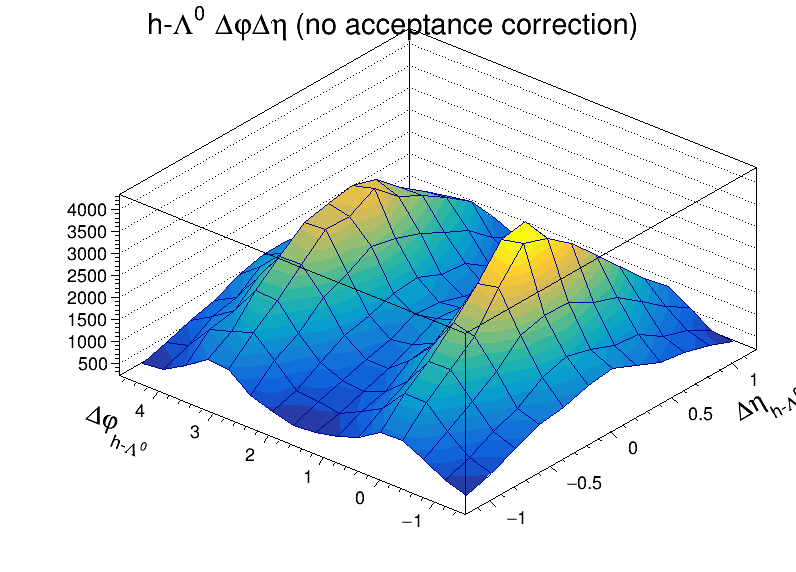

In [88]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_lambda_2d_nomixcor.Draw("SURF1")
c.Draw()

In [89]:
h_lambda_2d_nomixcor.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_mc.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)

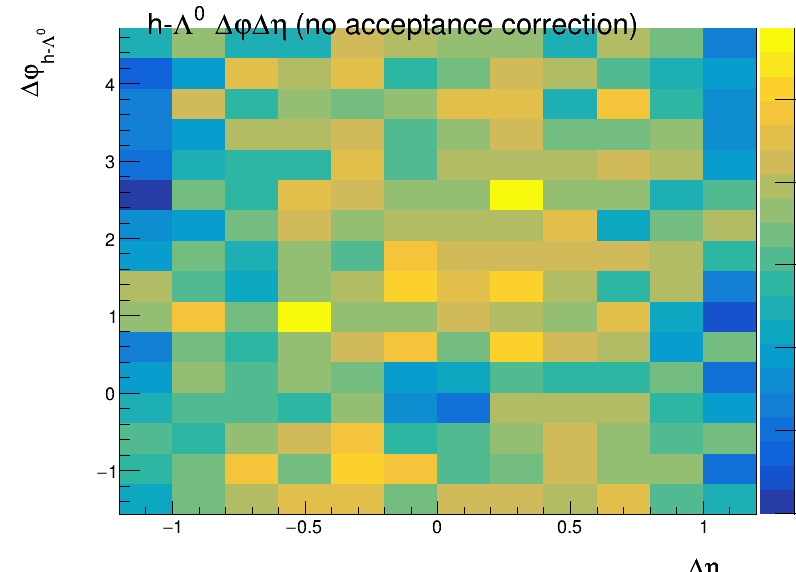

In [90]:
h_lambda_2d_ratio_nomixcor = h_lambda_2d_nomixcor.Clone("h_lambda_2d_ratio_nomixcor")
h_lambda_2d_ratio_nomixcor.Divide(h_lambda_2d_nomixcor_mc)
h_lambda_2d_ratio_nomixcor.Draw("colz")
c.Draw()

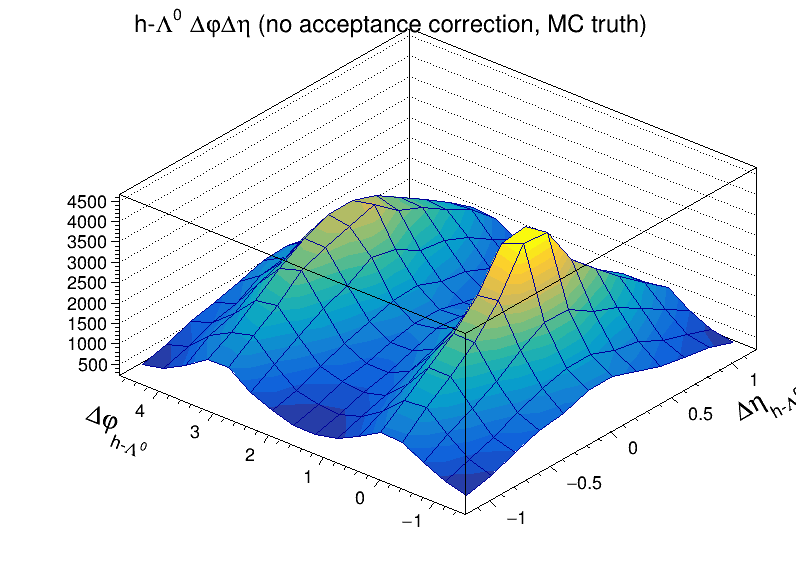

In [91]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_mc.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_mc.Draw("SURF1")
c.Draw()

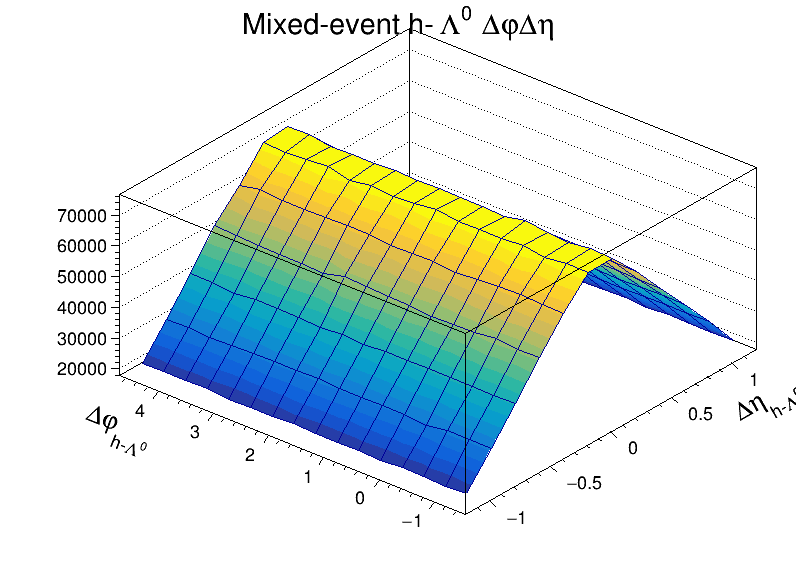

In [92]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_mixed_2d.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_lambda_mixed_2d.Draw("SURF1")
c.Draw()

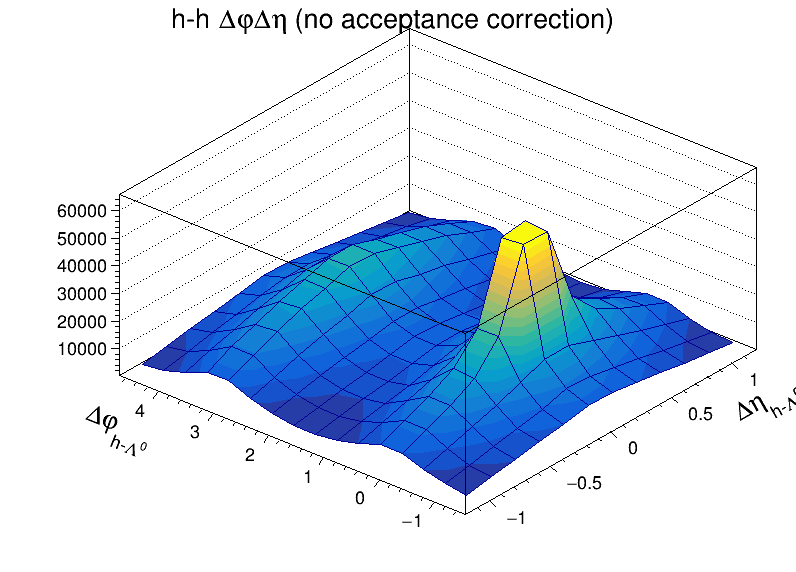

In [93]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_nomixcor.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_h_2d_nomixcor.Draw("SURF1")
c.Draw()

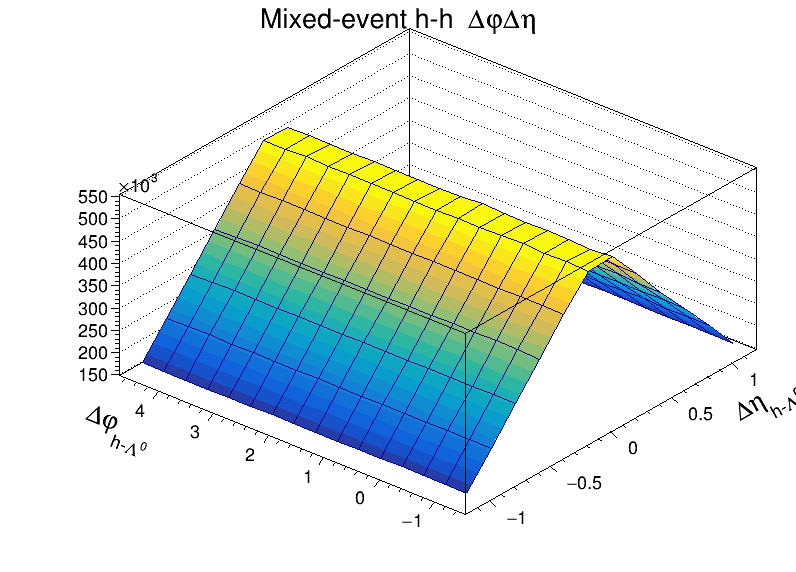

In [94]:
c.SetTheta(50)
c.SetPhi(50)
h_h_mixed_2d.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_h_mixed_2d.Draw("SURF1")
c.Draw()

In [95]:
h_lambda_2d_mixcor_sig = make_mixed_corrections(h_lambda, h_lambda_mixed, SIG_MIN, SIG_MAX)
h_lambda_2d_mixcor_rsb = make_mixed_corrections(h_lambda, h_lambda_mixed, RSB_MIN, RSB_MAX)

Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambdaEff_MCKin_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambdaMixed_MCKin_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).


In [96]:
h_lambda_2d_mixcor_sig_mc = make_mixed_corrections(h_lambda_mc, h_lambda_mixed_mc, SIG_MIN, SIG_MAX)

Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created


In [97]:
# h_lambda_2d_mixcor_sig.RebinX(2)
# h_lambda_2d_mixcor_sig_mc.RebinX(2)
h_lambda_2d_mixcor_sig_mc_ratio = h_lambda_2d_mixcor_sig.Clone("h_lambda_2d_mixcor_sig_mc_ratio")
h_lambda_2d_mixcor_sig_mc_ratio.Divide(h_lambda_2d_mixcor_sig_mc)

True

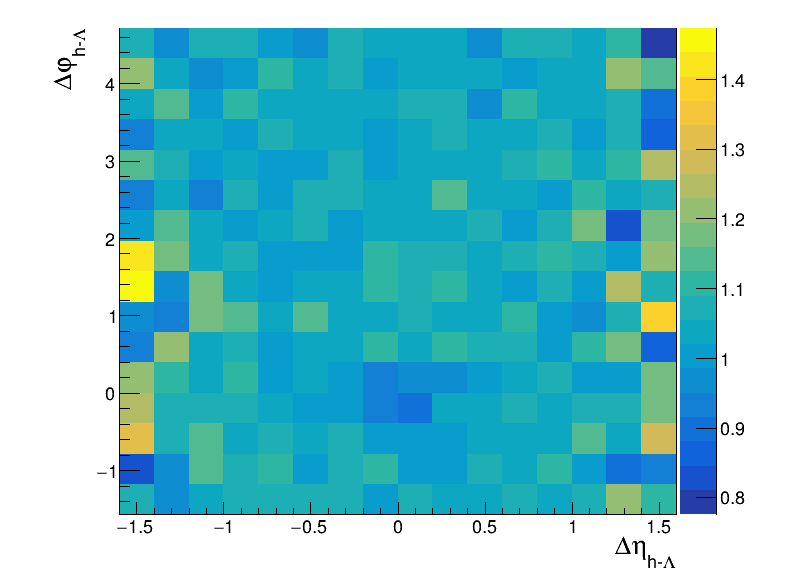

In [98]:
c.SetRightMargin(0.15)
h_lambda_2d_mixcor_sig_mc_ratio.SetTitle("")
h_lambda_2d_mixcor_sig_mc_ratio.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda}")
h_lambda_2d_mixcor_sig_mc_ratio.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda}")
h_lambda_2d_mixcor_sig_mc_ratio.GetYaxis().SetRangeUser(-rt.TMath.Pi()/2, 3*rt.TMath.Pi()/2)
h_lambda_2d_mixcor_sig_mc_ratio.GetXaxis().SetRangeUser(-1.6, 1.6 - 0.1)
h_lambda_2d_mixcor_sig_mc_ratio.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda}")
h_lambda_2d_mixcor_sig_mc_ratio.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_mc_ratio.GetXaxis().SetTitleOffset(0.8)
h_lambda_2d_mixcor_sig_mc_ratio.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_mc_ratio.GetYaxis().SetTitleOffset(0.8)
h_lambda_2d_mixcor_sig_mc_ratio.GetXaxis().SetRangeUser(-1.6, 1.6 - 0.1)

# if PT_MODE == 0:
#     template_file = rt.TFile("twotrack_template.root", "RECREATE")
# elif PT_MODE == 1:
#     template_file = rt.TFile("twotrack_template_lowpt.root", "RECREATE")
# elif PT_MODE == 2:
#     template_file = rt.TFile("twotrack_template_highpt.root", "RECREATE")
# template_file.cd()
# h_lambda_2d_mixcor_sig_mc_ratio.Write("twotrack_template")
# template_file.Close()

h_lambda_2d_mixcor_sig_mc_ratio.Draw("COLZ")
c.Draw()

In [99]:
h_h_2d_mixcor = make_mixed_corrections(h_h, h_h_mixed, SIG_MIN, SIG_MAX, is_hh=True)
h_h_2d_mixcor_mc = make_mixed_corrections(h_h_mc, h_h_mixed_mc, SIG_MIN, SIG_MAX, is_hh=True)

Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created


In [100]:
h_lambda_2d_mixcor_sig.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (SIG, acceptance corrected)")
h_lambda_2d_mixcor_sig.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_sig.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_rsb.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (RSB, acceptance corrected)")
h_lambda_2d_mixcor_rsb.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_rsb.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb.GetYaxis().SetTitleOffset(1.3)

In [101]:
h_h_2d_mixcor.SetTitle("h-h #Delta#varphi#Delta#eta correlation (acceptance corrected)")
h_h_2d_mixcor.GetYaxis().SetTitle("#Delta#varphi_{h-h}")
h_h_2d_mixcor.GetXaxis().SetTitle("#Delta#eta_{h-h}")
h_h_2d_mixcor.GetXaxis().SetTitleSize(0.05)
h_h_2d_mixcor.GetXaxis().SetTitleOffset(1.3)
h_h_2d_mixcor.GetYaxis().SetTitleSize(0.05)
h_h_2d_mixcor.GetYaxis().SetTitleOffset(1.3)

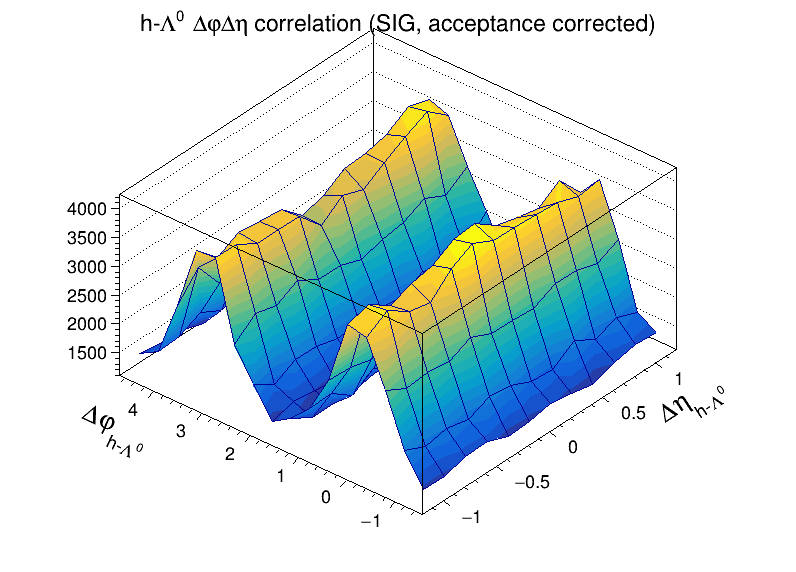

In [102]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_sig.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_lambda_2d_mixcor_sig.Draw("SURF1")
c.Draw()

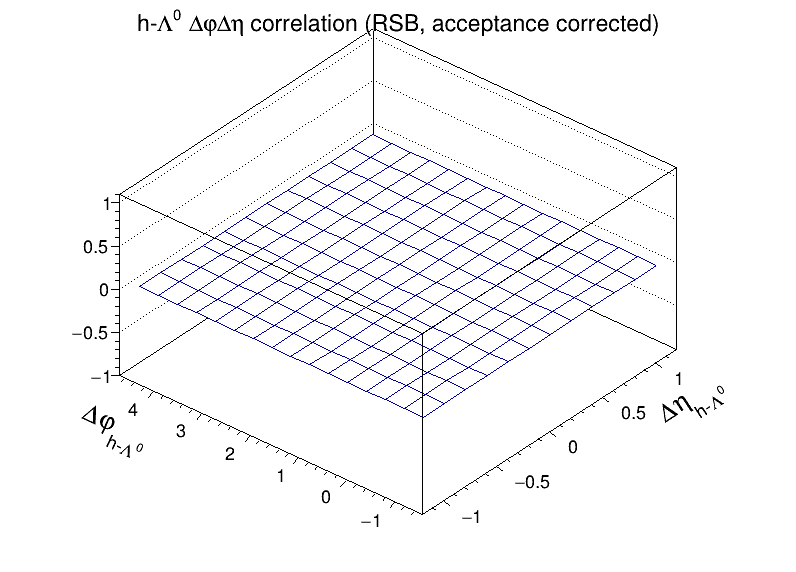

In [103]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_rsb.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_rsb.Draw("SURF1")
c.Draw()

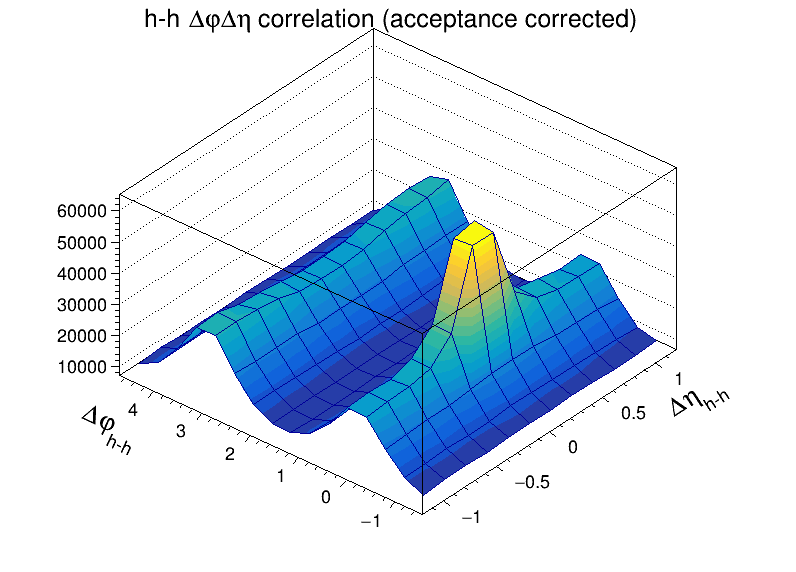

In [104]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_mixcor.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_mixcor.Draw("SURF1")
c.Draw()

In [105]:
h_lambda_2d_mixcor_sig_mc.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_h_2d_mixcor_mc.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)

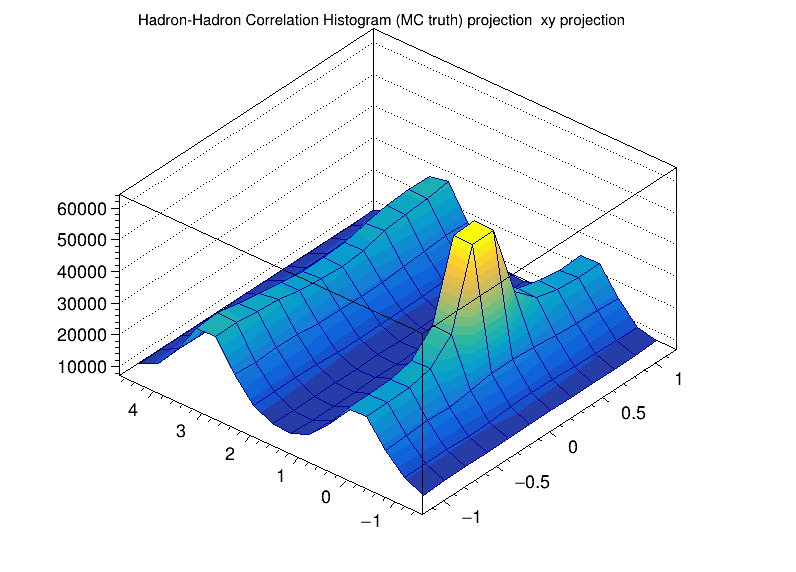

In [106]:
h_h_2d_mixcor_mc.Draw("SURF1")
c.Draw()

In [107]:
# per-trigger normalization done here
h_lambda_2d_mixcor_sig.Scale(1.0/num_trigs)
h_lambda_2d_mixcor_rsb.Scale(1.0/num_trigs)
h_lambda_2d_mixcor_sig_mc.Scale(1.0/num_trigs_mc)
h_h_2d_mixcor.Scale(1.0/num_trigs)
h_h_2d_mixcor_mc.Scale(1.0/num_trigs_mc)

Info in <TCanvas::Print>: pdf file h_pion_2d_secondary_05_15.pdf has been created


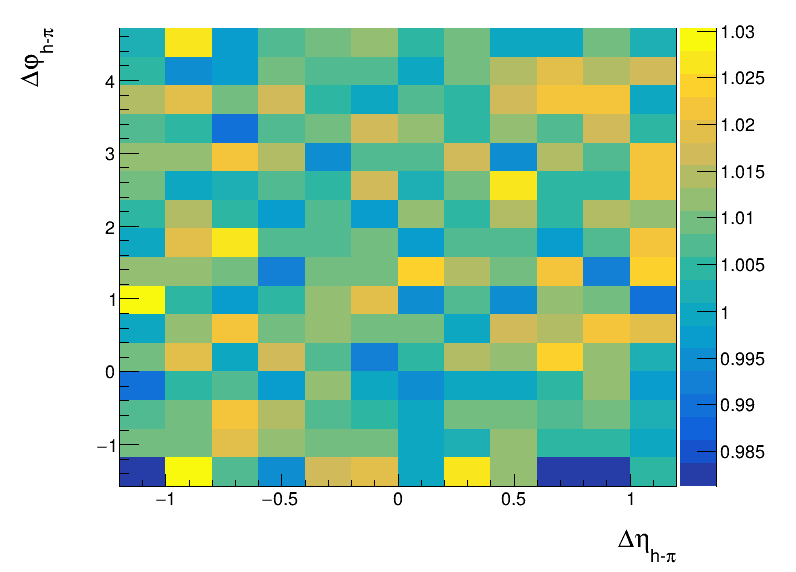

In [108]:
h_h_2d_ratio = h_h_2d_mixcor.Clone("h_h_2d_ratio")
h_h_2d_ratio.Divide(h_h_2d_mixcor_mc)
h_h_2d_ratio.SetTitle("")
h_h_2d_ratio.GetXaxis().SetTitle("#Delta#eta_{h-#pi}")
h_h_2d_ratio.GetYaxis().SetTitle("#Delta#varphi_{h-#pi}")
h_h_2d_ratio.Draw("COLZ")
c.SetLeftMargin(0.15)
c.SetBottomMargin(0.15)
c.SetRightMargin(0.15)
c.Draw()
c.SaveAs("h_pion_2d_secondary_05_15.pdf")

In [109]:
# scaling by total region/signal region scale factor done here (not done for MC kinematics since signal region is just a single narrow bin)
if not USE_MC_KINEMATICS:
    h_lambda_2d_mixcor_sig.Scale(scale_factor)
    h_lambda_2d_mixcor_rsb.Scale(scale_factor)

In [110]:
# MC truth does not need sideband subtraction
h_lambda_2d_subtracted_mc = h_lambda_2d_mixcor_sig_mc
h_lambda_2d_subtracted = h_lambda_2d_mixcor_sig

### Sideband subtraction section

In [111]:
h_lambda_2d_subtracted = h_lambda_2d_mixcor_sig.Clone("h_lambda_2d_subtracted")

# if DO_SIDEBAND_SUBTRACTION:
#     # Normalize side band to 1
#     h_lambda_2d_mixcor_rsb.Scale(1/h_lambda_2d_mixcor_rsb.Integral())
#     # using RSB for sideband subtraction (there is no LSB, signal is present)
#     bg_integral = (1 - lambda_signal_total_ratio)*h_lambda_2d_subtracted.Integral()
#     h_lambda_2d_subtracted.Add(h_lambda_2d_mixcor_rsb, -bg_integral)

# h_lambda_2d_subtracted = apply_two_track_correction(h_lambda_2d_subtracted, TWOTRACK_TEMPLATE)



# # drawing the subtracted 2-d correlation correlation
# h_lambda_2d_subtracted.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (acceptance corrected, right sideband subtracted)")
# h_lambda_2d_subtracted.Draw("SURF1")
# c.Draw()

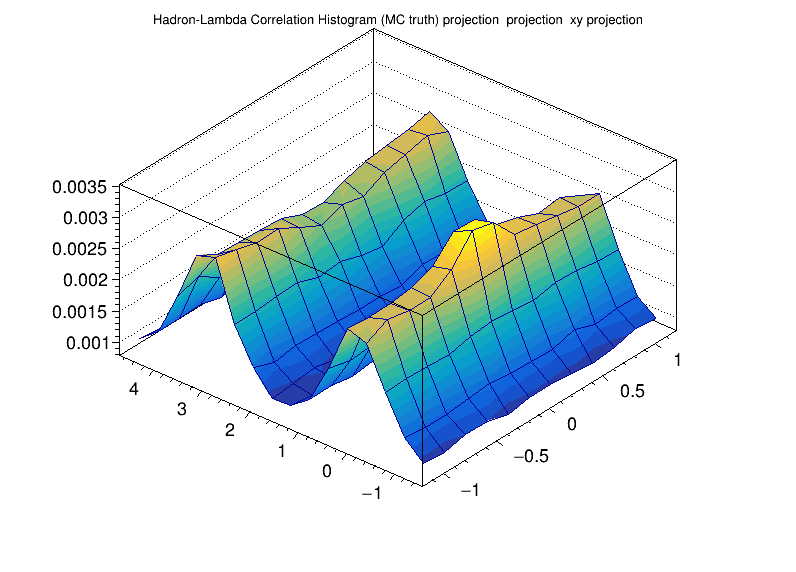

In [112]:
h_lambda_2d_subtracted_mc.Draw("SURF1")
c.Draw()

In [60]:
epos_out = rt.TFile("epos_0_80_2d_dists.root", "RECREATE")
epos_out.cd()
trig_dist_mc.Write("trig_dist")
h_h_2d_mixcor_mc.Write("h_h_2d")
h_lambda_2d_subtracted_mc.Write("h_lambda_2d")
epos_out.Close()

### Integral and ratio section

In [66]:
# h_lambda_2d_subtracted.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
# h_lambda_dphi_subtracted_p1 = h_lambda_2d_subtracted.ProjectionY("h_lambda_dphi_subtracted_p1")
# h_lambda_2d_subtracted.GetXaxis().SetRangeUser(-DELTA_ETA_MAX + EPSILON, -DELTA_ETA_MIN - EPSILON)
# h_lambda_dphi_subtracted_p2 = h_lambda_2d_subtracted.ProjectionY("h_lambda_dphi_subtracted_p2")
# h_lambda_dphi_subtracted_p1.Add(h_lambda_dphi_subtracted_p2)

In [67]:
# h_lambda_2d_subtracted_mc.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
# h_lambda_dphi_subtracted_p1_mc = h_lambda_2d_subtracted.ProjectionY("h_lambda_dphi_subtracted_p1_mc")
# h_lambda_2d_subtracted_mc.GetXaxis().SetRangeUser(-DELTA_ETA_MAX + EPSILON, -DELTA_ETA_MIN - EPSILON)
# h_lambda_dphi_subtracted_p2_mc = h_lambda_2d_subtracted.ProjectionY("h_lambda_dphi_subtracted_p2_mc")
# h_lambda_dphi_subtracted_p1_mc.Add(h_lambda_dphi_subtracted_p2_mc)

In [68]:
h_lambda_dphi_subtracted = h_lambda_2d_subtracted.ProjectionY("h_lambda_dphi_subtracted")
h_lambda_dphi_subtracted.SetTitle("")
h_lambda_dphi_subtracted.SetMarkerStyle(43)
h_lambda_dphi_subtracted.SetLineColor(rt.kRed - 7)
h_lambda_dphi_subtracted.SetMarkerColor(rt.kRed - 7)
h_lambda_dphi_subtracted.SetMarkerSize(2)
h_lambda_dphi_subtracted.SetLineWidth(2)
h_lambda_dphi_subtracted.GetYaxis().SetTitle("#frac{dN_{h-#Lambda}}{d#Delta#varphi}")
h_lambda_dphi_subtracted.GetXaxis().SetTitle("#Delta#varphi_{h-#Lambda}")
h_lambda_dphi_subtracted.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted.GetXaxis().SetTitleOffset(0.5)

In [69]:
h_lambda_dphi_subtracted_mc = h_lambda_2d_subtracted_mc.ProjectionY("h_lambda_dphi_subtracted_mc")
h_lambda_dphi_subtracted_mc.SetTitle("")
h_lambda_dphi_subtracted_mc.SetMarkerStyle(34)
h_lambda_dphi_subtracted_mc.SetLineColor(rt.kViolet + 7)
h_lambda_dphi_subtracted_mc.SetMarkerColor(rt.kViolet + 7)
h_lambda_dphi_subtracted_mc.SetMarkerSize(1.5)
h_lambda_dphi_subtracted_mc.SetLineWidth(2)
h_lambda_dphi_subtracted_mc.GetYaxis().SetTitle("#frac{dN_{h-#Lambda}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_mc.GetXaxis().SetTitle("#Delta#varphi_{h-#Lambda}")
h_lambda_dphi_subtracted_mc.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_mc.GetXaxis().SetTitleOffset(0.5)

In [70]:
h_lambda_dphi_subtracted.Scale(h_lambda_dphi_subtracted_mc.Integral(1, 1)/h_lambda_dphi_subtracted.Integral(1, 1))

In [71]:
h_lambda_dphi_subtracted_mc.GetYaxis().SetRangeUser(h_lambda_dphi_subtracted_mc.GetMinimum()*0.8, h_lambda_dphi_subtracted_mc.GetMaximum()*1.2)

In [72]:
comp_legend = rt.TLegend(0.6, 0.75, 0.9, 0.85)
comp_legend.SetBorderSize(0)
comp_legend.SetFillStyle(0)
comp_legend.SetTextSize(0.04)
comp_legend.AddEntry(h_lambda_dphi_subtracted, "Reconstructed", "lep")
comp_legend.AddEntry(h_lambda_dphi_subtracted_mc, "Ground-truth", "lep")

Info in <TCanvas::Print>: pdf file figures/h_lambda_dphi_closure.pdf has been created


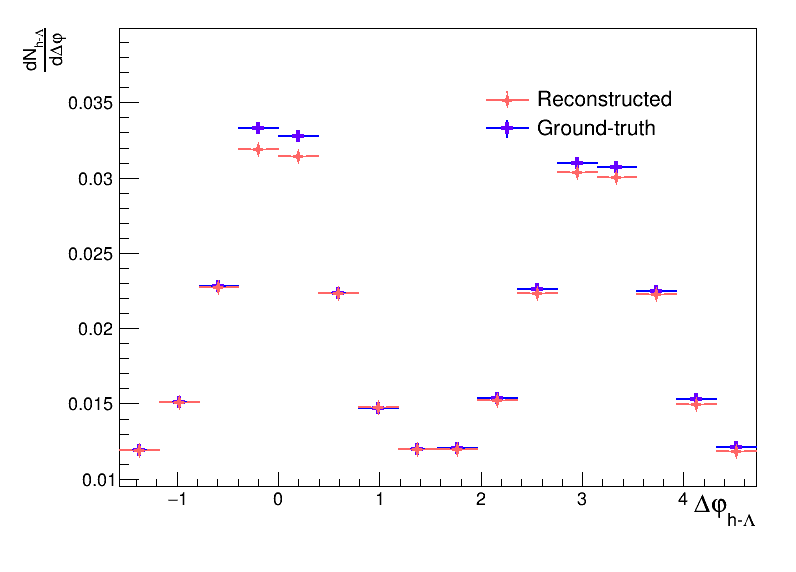

In [73]:
h_lambda_dphi_subtracted_mc.SetLineColor(rt.kBlue)
h_lambda_dphi_subtracted_mc.Draw()
h_lambda_dphi_subtracted.Draw("SAME")
comp_legend.Draw("SAME")

c.SetLeftMargin(0.15)
c.SetRightMargin(0.05)
c.SetTopMargin(0.05)



c.Draw()

if PT_MODE == 0:
    c.SaveAs("figures/h_lambda_dphi_closure.pdf")
elif PT_MODE == 1:
    c.SaveAs("figures/h_lambda_dphi_closure_lowpt.pdf")
elif PT_MODE == 2:
    c.SaveAs("figures/h_lambda_dphi_closure_highpt.pdf")

In [ ]:
h_lambda_closure_ratio_fit = rt.TF1("h_lambda_closure_ratio_fit", "pol0", -2, 5)
h_lambda_closure_ratio_fit.SetLineColor(rt.kBlack)
h_lambda_closure_ratio_fit_plus = rt.TF1("h_lambda_closure_ratio_fit_plus", "pol0", -2, 5)
h_lambda_closure_ratio_fit_plus.SetLineColor(rt.kBlack)
h_lambda_closure_ratio_fit_minus = rt.TF1("h_lambda_closure_ratio_fit_minus", "pol0", -2, 5)
h_lambda_closure_ratio_fit_minus.SetLineColor(rt.kBlack)
h_lambda_closure_ratio_fit_plus.SetLineStyle(10)
h_lambda_closure_ratio_fit_plus.SetLineWidth(1)
h_lambda_closure_ratio_fit_minus.SetLineStyle(10)
h_lambda_closure_ratio_fit_minus.SetLineWidth(1)
h_lambda_closure_ratio_fit.SetLineStyle(10)
h_lambda_closure_ratio_fit.SetLineWidth(2)
h_lambda_dphi_ratio = h_lambda_dphi_subtracted.Clone("h_lambda_dphi_ratio")
h_lambda_dphi_ratio.SetTitle("")
h_lambda_dphi_ratio.GetYaxis().SetTitle("#frac{Reconstructed}{Ground-truth}")
h_lambda_dphi_ratio.Divide(h_lambda_dphi_subtracted_mc)
h_lambda_dphi_ratio.Fit(h_lambda_closure_ratio_fit)
h_lambda_dphi_ratio.GetYaxis().SetRangeUser(0.8, 1.2)
h_lambda_dphi_ratio.Draw()
h_lambda_closure_ratio_fit_minus.SetParameter(0, h_lambda_closure_ratio_fit.GetParameter(0) - h_lambda_closure_ratio_fit.GetParError(0))
h_lambda_closure_ratio_fit_plus.SetParameter(0, h_lambda_closure_ratio_fit.GetParameter(0) + h_lambda_closure_ratio_fit.GetParError(0))
h_lambda_closure_ratio_fit_minus.Draw("SAME")
h_lambda_closure_ratio_fit_plus.Draw("SAME")

leg = rt.TLegend(0.6, 0.7, 0.85, 0.85)
leg.AddEntry(h_lambda_dphi_ratio, "Reco/ground", "lep")
leg.AddEntry(h_lambda_closure_ratio_fit, "Fit", "l")
leg.SetBorderSize(0)
leg.Draw("same")
c.Draw()

if PT_MODE == 0:
    c.SaveAs("figures/h_lambda_dphi_closure_ratio.pdf")
elif PT_MODE == 1:
    c.SaveAs("figures/h_lambda_dphi_closure_ratio_lowpt.pdf")
elif PT_MODE == 2:
    c.SaveAs("figures/h_lambda_dphi_closure_ratio_highpt.pdf")

In [ ]:
if USE_AVG:
    ue_line = rt.TF1("ue_line", "pol0", -2, 6)
    ue_upper_line = rt.TF1("ue_upper_line", "pol0", -2, 6)
    ue_lower_line = rt.TF1("ue_lower_line", "pol0", -2, 6)
    zero_line = rt.TF1("zero_line", "pol0", -2, 6)
    zero_upper_line = rt.TF1("zero_upper_line", "pol0", -2, 6)
    zero_lower_line = rt.TF1("zero_lower_line", "pol0", -2, 6)
    ue_avg = (h_lambda_dphi_subtracted.GetBinContent(1) 
                   + h_lambda_dphi_subtracted.GetBinContent(2)
                   + h_lambda_dphi_subtracted.GetBinContent(7)
                   + h_lambda_dphi_subtracted.GetBinContent(8)
                   + h_lambda_dphi_subtracted.GetBinContent(9)
                   + h_lambda_dphi_subtracted.GetBinContent(16))/6

    ue_avg_error = (1/6)*(math.sqrt(h_lambda_dphi_subtracted.GetBinError(1)**2 
                   + h_lambda_dphi_subtracted.GetBinError(2)**2
                   + h_lambda_dphi_subtracted.GetBinError(7)**2
                   + h_lambda_dphi_subtracted.GetBinError(8)**2
                   + h_lambda_dphi_subtracted.GetBinError(9)**2
                   + h_lambda_dphi_subtracted.GetBinError(16)**2))


    ue_line.SetParameter(0, ue_avg)
    ue_line.SetLineColor(rt.kViolet - 6)
    ue_line.SetLineWidth(3)
    ue_line.SetLineStyle(rt.kSolid)

    ue_upper_line.SetParameter(0, ue_avg + ue_avg_error)
    ue_upper_line.SetLineColor(rt.kViolet - 6)
    ue_upper_line.SetLineStyle(rt.kDashed)

    ue_lower_line.SetParameter(0, ue_avg - ue_avg_error)
    ue_lower_line.SetLineColor(rt.kViolet - 6)
    ue_lower_line.SetLineStyle(rt.kDashed)

    zero_line.SetParameter(0, 0)
    zero_line.SetLineColor(rt.kViolet - 6)
    zero_line.SetLineWidth(3)
    zero_line.SetLineStyle(rt.kSolid)
    zero_upper_line.SetParameter(0, ue_avg_error)
    zero_upper_line.SetLineColor(rt.kViolet - 6)
    zero_upper_line.SetLineStyle(rt.kDashed)
    zero_lower_line.SetParameter(0, -ue_avg_error)
    zero_lower_line.SetLineColor(rt.kViolet - 6)
    zero_lower_line.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    ue_line = rt.TF1("ue_line", "pol0", -2, 6)
    ue_upper_line = rt.TF1("ue_upper_line", "pol0", -2, 6)
    ue_lower_line = rt.TF1("ue_lower_line", "pol0", -2, 6)
    zero_line = rt.TF1("zero_line", "pol0", -2, 6)
    zero_upper_line = rt.TF1("zero_upper_line", "pol0", -2, 6)
    zero_lower_line = rt.TF1("zero_lower_line", "pol0", -2, 6)
    min_bin = h_lambda_dphi_subtracted.GetMinimumBin()
    ue_avg = h_lambda_dphi_subtracted.GetBinContent(min_bin)
    ue_avg_error = h_lambda_dphi_subtracted.GetBinError(min_bin)


    ue_line.SetParameter(0, ue_avg)
    ue_line.SetLineColor(rt.kViolet - 6)
    ue_line.SetLineWidth(3)
    ue_line.SetLineStyle(rt.kSolid)

    ue_upper_line.SetParameter(0, ue_avg + ue_avg_error)
    ue_upper_line.SetLineColor(rt.kViolet - 6)
    ue_upper_line.SetLineStyle(rt.kDashed)

    ue_lower_line.SetParameter(0, ue_avg - ue_avg_error)
    ue_lower_line.SetLineColor(rt.kViolet - 6)
    ue_lower_line.SetLineStyle(rt.kDashed)

    zero_line.SetParameter(0, 0)
    zero_line.SetLineColor(rt.kViolet - 6)
    zero_line.SetLineWidth(3)
    zero_line.SetLineStyle(rt.kSolid)
    zero_upper_line.SetParameter(0, ue_avg_error)
    zero_upper_line.SetLineColor(rt.kViolet - 6)
    zero_upper_line.SetLineStyle(rt.kDashed)
    zero_lower_line.SetParameter(0, -ue_avg_error)
    zero_lower_line.SetLineColor(rt.kViolet - 6)
    zero_lower_line.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
if USE_AVG:
    ue_line_mc = rt.TF1("ue_line_mc", "pol0", -2, 6)
    ue_upper_line_mc = rt.TF1("ue_upper_line_mc", "pol0", -2, 6)
    ue_lower_line_mc = rt.TF1("ue_lower_line_mc", "pol0", -2, 6)
    zero_line_mc = rt.TF1("zero_line_mc", "pol0", -2, 6)
    zero_upper_line_mc = rt.TF1("zero_upper_line_mc", "pol0", -2, 6)
    zero_lower_line_mc = rt.TF1("zero_lower_line_mc", "pol0", -2, 6)
    ue_avg_mc = (h_lambda_dphi_subtracted_mc.GetBinContent(1) 
                   + h_lambda_dphi_subtracted_mc.GetBinContent(2)
                   + h_lambda_dphi_subtracted_mc.GetBinContent(7)
                   + h_lambda_dphi_subtracted_mc.GetBinContent(8)
                   + h_lambda_dphi_subtracted_mc.GetBinContent(9)
                   + h_lambda_dphi_subtracted_mc.GetBinContent(16))/6

    ue_avg_error_mc = (1/6)*(math.sqrt(h_lambda_dphi_subtracted_mc.GetBinError(1)**2 
                   + h_lambda_dphi_subtracted_mc.GetBinError(2)**2
                   + h_lambda_dphi_subtracted_mc.GetBinError(7)**2
                   + h_lambda_dphi_subtracted_mc.GetBinError(8)**2
                   + h_lambda_dphi_subtracted_mc.GetBinError(9)**2
                   + h_lambda_dphi_subtracted_mc.GetBinError(16)**2))


    ue_line_mc.SetParameter(0, ue_avg_mc)
    ue_line_mc.SetLineColor(rt.kViolet - 6)
    ue_line_mc.SetLineWidth(3)
    ue_line_mc.SetLineStyle(rt.kSolid)

    ue_upper_line_mc.SetParameter(0, ue_avg_mc + ue_avg_error_mc)
    ue_upper_line_mc.SetLineColor(rt.kViolet - 6)
    ue_upper_line_mc.SetLineStyle(rt.kDashed)

    ue_lower_line_mc.SetParameter(0, ue_avg_mc - ue_avg_error_mc)
    ue_lower_line_mc.SetLineColor(rt.kViolet - 6)
    ue_lower_line_mc.SetLineStyle(rt.kDashed)

    zero_line_mc.SetParameter(0, 0)
    zero_line_mc.SetLineColor(rt.kViolet - 6)
    zero_line_mc.SetLineWidth(3)
    zero_line_mc.SetLineStyle(rt.kSolid)
    zero_upper_line_mc.SetParameter(0, ue_avg_error_mc)
    zero_upper_line_mc.SetLineColor(rt.kViolet - 6)
    zero_upper_line_mc.SetLineStyle(rt.kDashed)
    zero_lower_line_mc.SetParameter(0, -ue_avg_error_mc)
    zero_lower_line_mc.SetLineColor(rt.kViolet - 6)
    zero_lower_line_mc.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    ue_line_mc = rt.TF1("ue_line_mc", "pol0", -2, 6)
    ue_upper_line_mc = rt.TF1("ue_upper_line_mc", "pol0", -2, 6)
    ue_lower_line_mc = rt.TF1("ue_lower_line_mc", "pol0", -2, 6)
    zero_line_mc = rt.TF1("zero_line_mc", "pol0", -2, 6)
    zero_upper_line_mc = rt.TF1("zero_upper_line_mc", "pol0", -2, 6)
    zero_lower_line_mc = rt.TF1("zero_lower_line_mc", "pol0", -2, 6)
    min_bin = h_lambda_dphi_subtracted_mc.GetMinimumBin()
    ue_avg_mc = h_lambda_dphi_subtracted_mc.GetBinContent(min_bin)
    ue_avg_error_mc = h_lambda_dphi_subtracted_mc.GetBinError(min_bin)


    ue_line_mc.SetParameter(0, ue_avg_mc)
    ue_line_mc.SetLineColor(rt.kViolet - 6)
    ue_line_mc.SetLineWidth(3)
    ue_line_mc.SetLineStyle(rt.kSolid)

    ue_upper_line_mc.SetParameter(0, ue_avg_mc + ue_avg_error_mc)
    ue_upper_line_mc.SetLineColor(rt.kViolet - 6)
    ue_upper_line_mc.SetLineStyle(rt.kDashed)

    ue_lower_line_mc.SetParameter(0, ue_avg_mc - ue_avg_error_mc)
    ue_lower_line_mc.SetLineColor(rt.kViolet - 6)
    ue_lower_line_mc.SetLineStyle(rt.kDashed)

    zero_line_mc.SetParameter(0, 0)
    zero_line_mc.SetLineColor(rt.kViolet - 6)
    zero_line_mc.SetLineWidth(3)
    zero_line_mc.SetLineStyle(rt.kSolid)
    zero_upper_line_mc.SetParameter(0, ue_avg_error_mc)
    zero_upper_line_mc.SetLineColor(rt.kViolet - 6)
    zero_upper_line_mc.SetLineStyle(rt.kDashed)
    zero_lower_line_mc.SetParameter(0, -ue_avg_error_mc)
    zero_lower_line_mc.SetLineColor(rt.kViolet - 6)
    zero_lower_line_mc.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
min_bin = h_lambda_dphi_subtracted.GetMinimumBin()
min_val = h_lambda_dphi_subtracted.GetBinContent(min_bin)
max_bin = h_lambda_dphi_subtracted.GetMaximumBin()
max_val = h_lambda_dphi_subtracted.GetBinContent(max_bin)

h_lambda_dphi_subtracted.GetYaxis().SetRangeUser(0.85*min_val, 1.15*max_val)
h_lambda_dphi_subtracted.Draw()
ue_line.Draw("SAME")
ue_upper_line.Draw("SAME")
ue_lower_line.Draw("SAME")
c.Draw()

In [ ]:
h_lambda_dphi_subtracted.GetYaxis().SetRangeUser(0, 1.15*max_val)
h_lambda_dphi_subtracted.Draw()
ue_line.Draw("SAME")
ue_upper_line.Draw("SAME")
ue_lower_line.Draw("SAME")
c.Draw()

In [ ]:
h_lambda_dphi_subtracted_zeroed = h_lambda_dphi_subtracted.Clone("h_lambda_dphi_subtracted_zeroed")
h_lambda_dphi_subtracted_zeroed.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (UE subtracted, 0 - 20 multiplicity bin)")
h_lambda_dphi_subtracted_zeroed.Add(ue_line, -1)
h_lambda_dphi_subtracted_zeroed.Draw()
zero_line.Draw("SAME")
zero_upper_line.Draw("SAME")
zero_lower_line.Draw("SAME")
c.Draw()

In [ ]:
DPHI_BINS = h_lambda_dphi_subtracted.GetNbinsX()

In [ ]:
h_lambda_total_integral = 0
h_lambda_near_integral = 0
h_lambda_away_integral = 0
h_lambda_ue_integral = ue_avg*DPHI_BINS

h_lambda_total_integral_error = 0
h_lambda_near_integral_error = 0
h_lambda_away_integral_error = 0
h_lambda_ue_integral_error = ue_avg_error*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral += h_lambda_dphi_subtracted.GetBinContent(bin_num)
    h_lambda_total_integral_error += h_lambda_dphi_subtracted.GetBinError(bin_num)**2
    part = h_lambda_dphi_subtracted.GetBinContent(bin_num) - ue_avg
    if part < 0:
        continue
    if bin_num < 9:
        h_lambda_near_integral += part
        h_lambda_near_integral_error += h_lambda_dphi_subtracted.GetBinError(bin_num)**2
        h_lambda_near_integral_error += ue_avg_error**2
    else:
        h_lambda_away_integral += part
        h_lambda_away_integral_error += h_lambda_dphi_subtracted.GetBinError(bin_num)**2
        h_lambda_away_integral_error += ue_avg_error**2
h_lambda_total_integral_error = math.sqrt(h_lambda_total_integral_error)
h_lambda_near_integral_error = math.sqrt(h_lambda_near_integral_error)
h_lambda_away_integral_error = math.sqrt(h_lambda_away_integral_error)

In [ ]:
h_lambda_total_integral_mc = 0
h_lambda_near_integral_mc = 0
h_lambda_away_integral_mc = 0
h_lambda_ue_integral_mc = ue_avg_mc*DPHI_BINS

h_lambda_total_integral_error_mc = 0
h_lambda_near_integral_error_mc = 0
h_lambda_away_integral_error_mc = 0
h_lambda_ue_integral_error_mc = ue_avg_error_mc*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_mc += h_lambda_dphi_subtracted_mc.GetBinContent(bin_num)
    h_lambda_total_integral_error_mc += h_lambda_dphi_subtracted_mc.GetBinError(bin_num)**2
    part = h_lambda_dphi_subtracted_mc.GetBinContent(bin_num) - ue_avg_mc
    if part < 0:
        continue
    if bin_num < 9:
        h_lambda_near_integral_mc += part 
        h_lambda_near_integral_error_mc += h_lambda_dphi_subtracted_mc.GetBinError(bin_num)**2
        h_lambda_near_integral_error_mc += ue_avg_error_mc**2
    else:
        h_lambda_away_integral_mc += part 
        h_lambda_away_integral_error_mc += h_lambda_dphi_subtracted_mc.GetBinError(bin_num)**2
        h_lambda_away_integral_error_mc += ue_avg_error_mc**2
h_lambda_total_integral_error_mc = math.sqrt(h_lambda_total_integral_error_mc)
h_lambda_near_integral_error_mc = math.sqrt(h_lambda_near_integral_error_mc)
h_lambda_away_integral_error_mc = math.sqrt(h_lambda_away_integral_error_mc)

In [ ]:
h_h_dphi = h_h_2d_mixcor.ProjectionY("h_h_dphi")
h_h_dphi.SetTitle("")
h_h_dphi.SetLineColor(rt.kRed + 2)
h_h_dphi.SetMarkerStyle(43)
h_h_dphi.SetMarkerSize(3)
h_h_dphi.SetMarkerColor(rt.kRed + 2)
h_h_dphi.SetLineWidth(2)
h_h_dphi.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi.GetXaxis().SetTitleSize(0.05)
h_h_dphi.GetXaxis().SetTitleOffset(0.5)
h_h_dphi.GetXaxis().SetTitle("#Delta#varphi_{h-h} (rad)")
h_h_dphi.GetXaxis().SetTitleOffset(0.8)

In [ ]:
h_h_dphi_mc = h_h_2d_mixcor_mc.ProjectionY("h_h_dphi_mc")
h_h_dphi_mc.SetTitle("")
h_h_dphi_mc.SetLineColor(rt.kBlue - 2)
h_h_dphi_mc.SetMarkerColor(rt.kBlue - 2)
h_h_dphi_mc.SetMarkerStyle(34)
h_h_dphi_mc.SetMarkerSize(3)
h_h_dphi_mc.SetLineWidth(3)
h_h_dphi_mc.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi_mc.GetXaxis().SetTitleSize(0.05)
h_h_dphi_mc.GetXaxis().SetTitle("#Delta#varphi_{h-h} (rad)")
h_h_dphi_mc.GetXaxis().SetTitleOffset(0.8)

In [ ]:
h_h_dphi_mc.GetYaxis().SetRangeUser(h_h_dphi_mc.GetMinimum()*0.8, h_h_dphi_mc.GetMaximum()*1.2)

In [ ]:
h_h_dphi_mc.Draw()
h_h_dphi.Draw("SAME")
c.Draw()

leg = rt.TLegend(0.6, 0.7, 0.85, 0.85)
leg.AddEntry(h_h_dphi, "Reco h-h", "lep")
leg.AddEntry(h_h_dphi_mc, "MC truth h-h", "lep")
leg.SetBorderSize(0)
leg.Draw("same")

if PT_MODE == 0:
    c.SaveAs("figures/h_h_dphi_closure.pdf")
elif PT_MODE == 1:
    c.SaveAs("figures/h_h_dphi_closure_lowpt.pdf")
elif PT_MODE == 2:
    c.SaveAs("figures/h_h_dphi_closure_highpt.pdf")

In [ ]:
hh_closure_ratio_fit = rt.TF1("hh_closure_ratio_fit", "pol0", -2, 5)
hh_closure_ratio_fit.SetLineColor(rt.kBlack)
hh_closure_ratio_fit_plus = rt.TF1("hh_closure_ratio_fit_plus", "pol0", -2, 5)
hh_closure_ratio_fit_plus.SetLineColor(rt.kBlack)
hh_closure_ratio_fit_minus = rt.TF1("hh_closure_ratio_fit_minus", "pol0", -2, 5)
hh_closure_ratio_fit_minus.SetLineColor(rt.kBlack)
hh_closure_ratio_fit_plus.SetLineStyle(10)
hh_closure_ratio_fit_plus.SetLineWidth(1)
hh_closure_ratio_fit_minus.SetLineStyle(10)
hh_closure_ratio_fit_minus.SetLineWidth(1)
hh_closure_ratio_fit.SetLineStyle(10)
hh_closure_ratio_fit.SetLineWidth(2)
h_h_dphi_ratio = h_h_dphi.Clone("h_h_dphi_ratio")
h_h_dphi_ratio.SetTitle("")
h_h_dphi_ratio.GetYaxis().SetTitle("#frac{Reconstructed}{Ground-truth}")

h_h_dphi_ratio.Divide(h_h_dphi_mc)
h_h_dphi_ratio.Fit(hh_closure_ratio_fit)

h_h_dphi_ratio.GetYaxis().SetRangeUser(0.8, 1.2)
h_h_dphi_ratio.Draw()
hh_closure_ratio_fit_minus.SetParameter(0, hh_closure_ratio_fit.GetParameter(0) - hh_closure_ratio_fit.GetParError(0))
hh_closure_ratio_fit_plus.SetParameter(0, hh_closure_ratio_fit.GetParameter(0) + hh_closure_ratio_fit.GetParError(0))
hh_closure_ratio_fit_minus.Draw("SAME")
hh_closure_ratio_fit_plus.Draw("SAME")

leg = rt.TLegend(0.6, 0.7, 0.85, 0.85)
leg.AddEntry(h_h_dphi_ratio, "Reco/ground", "lep")
leg.AddEntry(hh_closure_ratio_fit, "Fit", "l")
leg.SetBorderSize(0)
leg.Draw("same")

c.Draw()
if PT_MODE == 0:
    c.SaveAs("figures/h_h_dphi_closure_ratio.pdf")
elif PT_MODE == 1:
    c.SaveAs("figures/h_h_dphi_closure_ratio_lowpt.pdf")
elif PT_MODE == 2:
    c.SaveAs("figures/h_h_dphi_closure_ratio_highpt.pdf")

In [ ]:
if USE_AVG:
    hh_ue_line = rt.TF1("hh_ue_line", "pol0", -2, 6)
    hh_ue_upper_line = rt.TF1("hh_ue_upper_line", "pol0", -2, 6)
    hh_ue_lower_line = rt.TF1("hh_ue_lower_line", "pol0", -2, 6)
    hh_zero_line = rt.TF1("hh_zero_line", "pol0", -2, 6)
    hh_zero_upper_line = rt.TF1("hh_zero_upper_line", "pol0", -2, 6)
    hh_zero_lower_line = rt.TF1("hh_zero_lower_line", "pol0", -2, 6)
    hh_ue_avg = (h_h_dphi.GetBinContent(1) 
                   + h_h_dphi.GetBinContent(8)
                   + h_h_dphi.GetBinContent(9)
                   + h_h_dphi.GetBinContent(16))/4

    hh_ue_avg_error = (1/4)*(math.sqrt(h_h_dphi.GetBinError(1)**2 
                   + h_h_dphi.GetBinError(8)**2
                   + h_h_dphi.GetBinError(9)**2
                   + h_h_dphi.GetBinError(16)**2))


    hh_ue_line.SetParameter(0, hh_ue_avg)
    hh_ue_line.SetLineColor(rt.kBlue)
    hh_ue_line.SetLineWidth(3)
    hh_ue_line.SetLineStyle(rt.kSolid)

    hh_ue_upper_line.SetParameter(0, hh_ue_avg + hh_ue_avg_error)
    hh_ue_upper_line.SetLineColor(rt.kBlue)
    hh_ue_upper_line.SetLineStyle(rt.kDashed)

    hh_ue_lower_line.SetParameter(0, hh_ue_avg - hh_ue_avg_error)
    hh_ue_lower_line.SetLineColor(rt.kBlue)
    hh_ue_lower_line.SetLineStyle(rt.kDashed)

    hh_zero_line.SetParameter(0, 0)
    hh_zero_line.SetLineColor(rt.kBlue)
    hh_zero_line.SetLineWidth(3)
    hh_zero_line.SetLineStyle(rt.kSolid)
    hh_zero_upper_line.SetParameter(0, hh_ue_avg_error)
    hh_zero_upper_line.SetLineColor(rt.kBlue)
    hh_zero_upper_line.SetLineStyle(rt.kDashed)
    hh_zero_lower_line.SetParameter(0, -hh_ue_avg_error)
    hh_zero_lower_line.SetLineColor(rt.kBlue)
    hh_zero_lower_line.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    hh_ue_line = rt.TF1("hh_ue_line", "pol0", -2, 6)
    hh_ue_upper_line = rt.TF1("hh_ue_upper_line", "pol0", -2, 6)
    hh_ue_lower_line = rt.TF1("hh_ue_lower_line", "pol0", -2, 6)
    hh_zero_line = rt.TF1("hh_zero_line", "pol0", -2, 6)
    hh_zero_upper_line = rt.TF1("hh_zero_upper_line", "pol0", -2, 6)
    hh_zero_lower_line = rt.TF1("hh_zero_lower_line", "pol0", -2, 6)
    
    min_bin = h_h_dphi.GetMinimumBin()
    hh_ue_avg = h_h_dphi.GetBinContent(min_bin)
    hh_ue_avg_error = h_h_dphi.GetBinError(min_bin)

    hh_ue_line.SetParameter(0, hh_ue_avg)
    hh_ue_line.SetLineColor(rt.kBlue)
    hh_ue_line.SetLineWidth(3)
    hh_ue_line.SetLineStyle(rt.kSolid)

    hh_ue_upper_line.SetParameter(0, hh_ue_avg + hh_ue_avg_error)
    hh_ue_upper_line.SetLineColor(rt.kBlue)
    hh_ue_upper_line.SetLineStyle(rt.kDashed)

    hh_ue_lower_line.SetParameter(0, hh_ue_avg - hh_ue_avg_error)
    hh_ue_lower_line.SetLineColor(rt.kBlue)
    hh_ue_lower_line.SetLineStyle(rt.kDashed)

    hh_zero_line.SetParameter(0, 0)
    hh_zero_line.SetLineColor(rt.kBlue)
    hh_zero_line.SetLineWidth(3)
    hh_zero_line.SetLineStyle(rt.kSolid)
    hh_zero_upper_line.SetParameter(0, hh_ue_avg_error)
    hh_zero_upper_line.SetLineColor(rt.kBlue)
    hh_zero_upper_line.SetLineStyle(rt.kDashed)
    hh_zero_lower_line.SetParameter(0, -hh_ue_avg_error)
    hh_zero_lower_line.SetLineColor(rt.kBlue)
    hh_zero_lower_line.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
if USE_AVG:
    hh_ue_line_mc = rt.TF1("hh_ue_line_mc", "pol0", -2, 6)
    hh_ue_upper_line_mc = rt.TF1("hh_ue_upper_line_mc", "pol0", -2, 6)
    hh_ue_lower_line_mc = rt.TF1("hh_ue_lower_line_mc", "pol0", -2, 6)
    hh_zero_line_mc = rt.TF1("hh_zero_line_mc", "pol0", -2, 6)
    hh_zero_upper_line_mc = rt.TF1("hh_zero_upper_line_mc", "pol0", -2, 6)
    hh_zero_lower_line_mc = rt.TF1("hh_zero_lower_line_mc", "pol0", -2, 6)
    hh_ue_avg_mc = (h_h_dphi_mc.GetBinContent(1) 
                   + h_h_dphi_mc.GetBinContent(8)
                   + h_h_dphi_mc.GetBinContent(9)
                   + h_h_dphi_mc.GetBinContent(16))/4

    hh_ue_avg_error_mc = (1/4)*(math.sqrt(h_h_dphi_mc.GetBinError(1)**2 
                   + h_h_dphi_mc.GetBinError(8)**2
                   + h_h_dphi_mc.GetBinError(9)**2
                   + h_h_dphi_mc.GetBinError(16)**2))


    hh_ue_line_mc.SetParameter(0, hh_ue_avg_mc)
    hh_ue_line_mc.SetLineColor(rt.kBlue)
    hh_ue_line_mc.SetLineWidth(3)
    hh_ue_line_mc.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_mc.SetParameter(0, hh_ue_avg_mc + hh_ue_avg_error_mc)
    hh_ue_upper_line_mc.SetLineColor(rt.kBlue)
    hh_ue_upper_line_mc.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_mc.SetParameter(0, hh_ue_avg_mc - hh_ue_avg_error_mc)
    hh_ue_lower_line_mc.SetLineColor(rt.kBlue)
    hh_ue_lower_line_mc.SetLineStyle(rt.kDashed)

    hh_zero_line_mc.SetParameter(0, 0)
    hh_zero_line_mc.SetLineColor(rt.kBlue)
    hh_zero_line_mc.SetLineWidth(3)
    hh_zero_line_mc.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_mc.SetParameter(0, hh_ue_avg_error_mc)
    hh_zero_upper_line_mc.SetLineColor(rt.kBlue)
    hh_zero_upper_line_mc.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_mc.SetParameter(0, -hh_ue_avg_error_mc)
    hh_zero_lower_line_mc.SetLineColor(rt.kBlue)
    hh_zero_lower_line_mc.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    hh_ue_line_mc = rt.TF1("hh_ue_line_mc", "pol0", -2, 6)
    hh_ue_upper_line_mc = rt.TF1("hh_ue_upper_line_mc", "pol0", -2, 6)
    hh_ue_lower_line_mc = rt.TF1("hh_ue_lower_line_mc", "pol0", -2, 6)
    hh_zero_line_mc = rt.TF1("hh_zero_line_mc", "pol0", -2, 6)
    hh_zero_upper_line_mc = rt.TF1("hh_zero_upper_line_mc", "pol0", -2, 6)
    hh_zero_lower_line_mc = rt.TF1("hh_zero_lower_line_mc", "pol0", -2, 6)
    
    min_bin = h_h_dphi_mc.GetMinimumBin()
    hh_ue_avg_mc = h_h_dphi_mc.GetBinContent(min_bin)
    hh_ue_avg_error_mc = h_h_dphi_mc.GetBinError(min_bin)

    hh_ue_line_mc.SetParameter(0, hh_ue_avg_mc)
    hh_ue_line_mc.SetLineColor(rt.kBlue)
    hh_ue_line_mc.SetLineWidth(3)
    hh_ue_line_mc.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_mc.SetParameter(0, hh_ue_avg_mc + hh_ue_avg_error_mc)
    hh_ue_upper_line_mc.SetLineColor(rt.kBlue)
    hh_ue_upper_line_mc.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_mc.SetParameter(0, hh_ue_avg_mc - hh_ue_avg_error_mc)
    hh_ue_lower_line_mc.SetLineColor(rt.kBlue)
    hh_ue_lower_line_mc.SetLineStyle(rt.kDashed)

    hh_zero_line_mc.SetParameter(0, 0)
    hh_zero_line_mc.SetLineColor(rt.kBlue)
    hh_zero_line_mc.SetLineWidth(3)
    hh_zero_line_mc.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_mc.SetParameter(0, hh_ue_avg_error_mc)
    hh_zero_upper_line_mc.SetLineColor(rt.kBlue)
    hh_zero_upper_line_mc.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_mc.SetParameter(0, -hh_ue_avg_error_mc)
    hh_zero_lower_line_mc.SetLineColor(rt.kBlue)
    hh_zero_lower_line_mc.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
min_bin = h_h_dphi.GetMinimumBin()
min_val = h_h_dphi.GetBinContent(min_bin)
max_bin = h_h_dphi.GetMaximumBin()
max_val = h_h_dphi.GetBinContent(max_bin)

h_h_dphi.GetYaxis().SetRangeUser(0.85*min_val, 1.15*max_val)

h_h_dphi.Draw()
hh_ue_line.Draw("SAME")
hh_ue_upper_line.Draw("SAME")
hh_ue_lower_line.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi.GetYaxis().SetRangeUser(0, h_h_dphi.GetMaximum()*1.1)
h_h_dphi.Draw()
hh_ue_line.Draw("SAME")
hh_ue_upper_line.Draw("SAME")
hh_ue_lower_line.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi_zeroed = h_h_dphi.Clone("h_h_dphi_zeroed")
h_h_dphi_zeroed.SetTitle("h-h #Delta#varphi distribution (UE subtracted, 0 - 20 multiplicity bin)")
h_h_dphi_zeroed.Add(hh_ue_line, -1)
h_h_dphi_zeroed.Draw()
hh_zero_line.Draw("SAME")
hh_zero_upper_line.Draw("SAME")
hh_zero_lower_line.Draw("SAME")
c.Draw()

In [ ]:
h_h_total_integral = 0
h_h_near_integral = 0
h_h_away_integral = 0
h_h_ue_integral = hh_ue_avg*DPHI_BINS

h_h_total_integral_error = 0
h_h_near_integral_error = 0
h_h_away_integral_error = 0
h_h_ue_integral_error = hh_ue_avg_error*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral += h_h_dphi.GetBinContent(bin_num)
    h_h_total_integral_error += h_h_dphi.GetBinError(bin_num)**2
    part = h_h_dphi.GetBinContent(bin_num) - hh_ue_avg
    if part < 0:
        continue
    if bin_num < 9:
        h_h_near_integral += part
        h_h_near_integral_error += h_h_dphi.GetBinError(bin_num)**2
        h_h_near_integral_error += hh_ue_avg_error**2
    else:
        h_h_away_integral += part
        h_h_away_integral_error += h_h_dphi.GetBinError(bin_num)**2
        h_h_away_integral_error += hh_ue_avg_error**2
h_h_total_integral_error = math.sqrt(h_h_total_integral_error)
h_h_near_integral_error = math.sqrt(h_h_near_integral_error)
h_h_away_integral_error = math.sqrt(h_h_away_integral_error)

In [ ]:
h_h_total_integral_mc = 0
h_h_near_integral_mc = 0
h_h_away_integral_mc = 0
h_h_ue_integral_mc = hh_ue_avg_mc*DPHI_BINS

h_h_total_integral_error_mc = 0
h_h_near_integral_error_mc = 0
h_h_away_integral_error_mc = 0
h_h_ue_integral_error_mc = hh_ue_avg_error_mc*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral_mc += h_h_dphi_mc.GetBinContent(bin_num)
    h_h_total_integral_error_mc += h_h_dphi_mc.GetBinError(bin_num)**2
    part = h_h_dphi_mc.GetBinContent(bin_num) - hh_ue_avg_mc
    if part < 0:
        continue
    if bin_num < 9:
        h_h_near_integral_mc += part
        h_h_near_integral_error_mc += h_h_dphi_mc.GetBinError(bin_num)**2
        h_h_near_integral_error_mc += hh_ue_avg_error_mc**2
    else:
        h_h_away_integral_mc += part
        h_h_away_integral_error_mc += h_h_dphi_mc.GetBinError(bin_num)**2
        h_h_away_integral_error_mc += hh_ue_avg_error_mc**2
h_h_total_integral_error_mc = math.sqrt(h_h_total_integral_error_mc)
h_h_near_integral_error_mc = math.sqrt(h_h_near_integral_error_mc)
h_h_away_integral_error_mc = math.sqrt(h_h_away_integral_error_mc)

In [ ]:
near_ratio = h_lambda_near_integral/h_h_near_integral
away_ratio = h_lambda_away_integral/h_h_away_integral
ue_ratio = h_lambda_ue_integral/h_h_ue_integral
total_ratio = h_lambda_total_integral/h_h_total_integral

near_ratio_error = near_ratio*math.sqrt((h_lambda_near_integral_error/h_lambda_near_integral)**2
                                                 + (h_h_near_integral_error/h_h_near_integral)**2)
away_ratio_error = away_ratio*math.sqrt((h_lambda_away_integral_error/h_lambda_away_integral)**2
                                                 + (h_h_away_integral_error/h_h_away_integral)**2)
ue_ratio_error = ue_ratio*math.sqrt((h_lambda_ue_integral_error/h_lambda_ue_integral)**2
                                                 + (h_h_ue_integral_error/h_h_ue_integral)**2)
total_ratio_error = total_ratio*math.sqrt((h_lambda_total_integral_error/h_lambda_total_integral)**2
                                                 + (h_h_total_integral_error/h_h_total_integral)**2)

In [ ]:
near_ratio_mc = h_lambda_near_integral_mc/h_h_near_integral_mc
away_ratio_mc = h_lambda_away_integral_mc/h_h_away_integral_mc
ue_ratio_mc = h_lambda_ue_integral_mc/h_h_ue_integral_mc
total_ratio_mc = h_lambda_total_integral_mc/h_h_total_integral_mc

near_ratio_error_mc = near_ratio_mc*math.sqrt((h_lambda_near_integral_error_mc/h_lambda_near_integral_mc)**2
                                                 + (h_h_near_integral_error_mc/h_h_near_integral_mc)**2)
away_ratio_error_mc = away_ratio_mc*math.sqrt((h_lambda_away_integral_error_mc/h_lambda_away_integral_mc)**2
                                                 + (h_h_away_integral_error_mc/h_h_away_integral_mc)**2)
ue_ratio_error_mc = ue_ratio_mc*math.sqrt((h_lambda_ue_integral_error_mc/h_lambda_ue_integral_mc)**2
                                                 + (h_h_ue_integral_error_mc/h_h_ue_integral_mc)**2)
total_ratio_error_mc = total_ratio_mc*math.sqrt((h_lambda_total_integral_error_mc/h_lambda_total_integral_mc)**2
                                                 + (h_h_total_integral_error_mc/h_h_total_integral_mc)**2)